<span style="font-size: 24px">LAB 1 - WINE</span>

1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from seaborn import heatmap
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, classification_report,
                             precision_score, recall_score, f1_score, accuracy_score,
                             precision_recall_fscore_support)


2)

In [2]:
wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target

dataset_shape = df.shape # 1. Размерность
num_features = df.shape[1] - 1  # 2. Количество признаков (минус целевой класс)
class_counts = df['target'].value_counts() # 3. Количество целевых классов и объектов в каждом классе
missing_percentage = df.isnull().mean() * 100 # 4. Процент объектов с неопределенными признаками
description = df.describe() # 5. Ключевые характеристики датасета

# Выбор 3 классов и 4 количественных признаков
# В данном случае, так как в наборе данных только 3 класса, мы можем выбрать все три
selected_classes = df['target'].unique()
selected_features = ['alcohol', 'ash', 'magnesium', 'total_phenols'] # Выбираем четыре количественных признака
filtered_df = df[df['target'].isin(selected_classes)][['target'] + selected_features] # Фильтрация данных по выбранным классам и признакам
filtered_df = filtered_df.dropna() # Удаление строк с неопределенными значениями

print("Размерность всего датасета:", dataset_shape, end="\n\n")
print("Количество признаков:", num_features, end="\n\n")
print("Количество целевых классов и объектов в каждом классе:")
print(class_counts, end="\n\n")
print("Процент объектов с неопределенными элементами по каждому признаку:")
print(missing_percentage, end="\n\n")
print("Ключевые характеристики датасета:")
print(description, end="\n\n")
print("Отфильтрованный датасет:")
print(filtered_df)

Размерность всего датасета: (178, 14)

Количество признаков: 13

Количество целевых классов и объектов в каждом классе:
target
1    71
0    59
2    48
Name: count, dtype: int64

Процент объектов с неопределенными элементами по каждому признаку:
alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         0.0
target                          0.0
dtype: float64

Ключевые характеристики датасета:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517        

3)

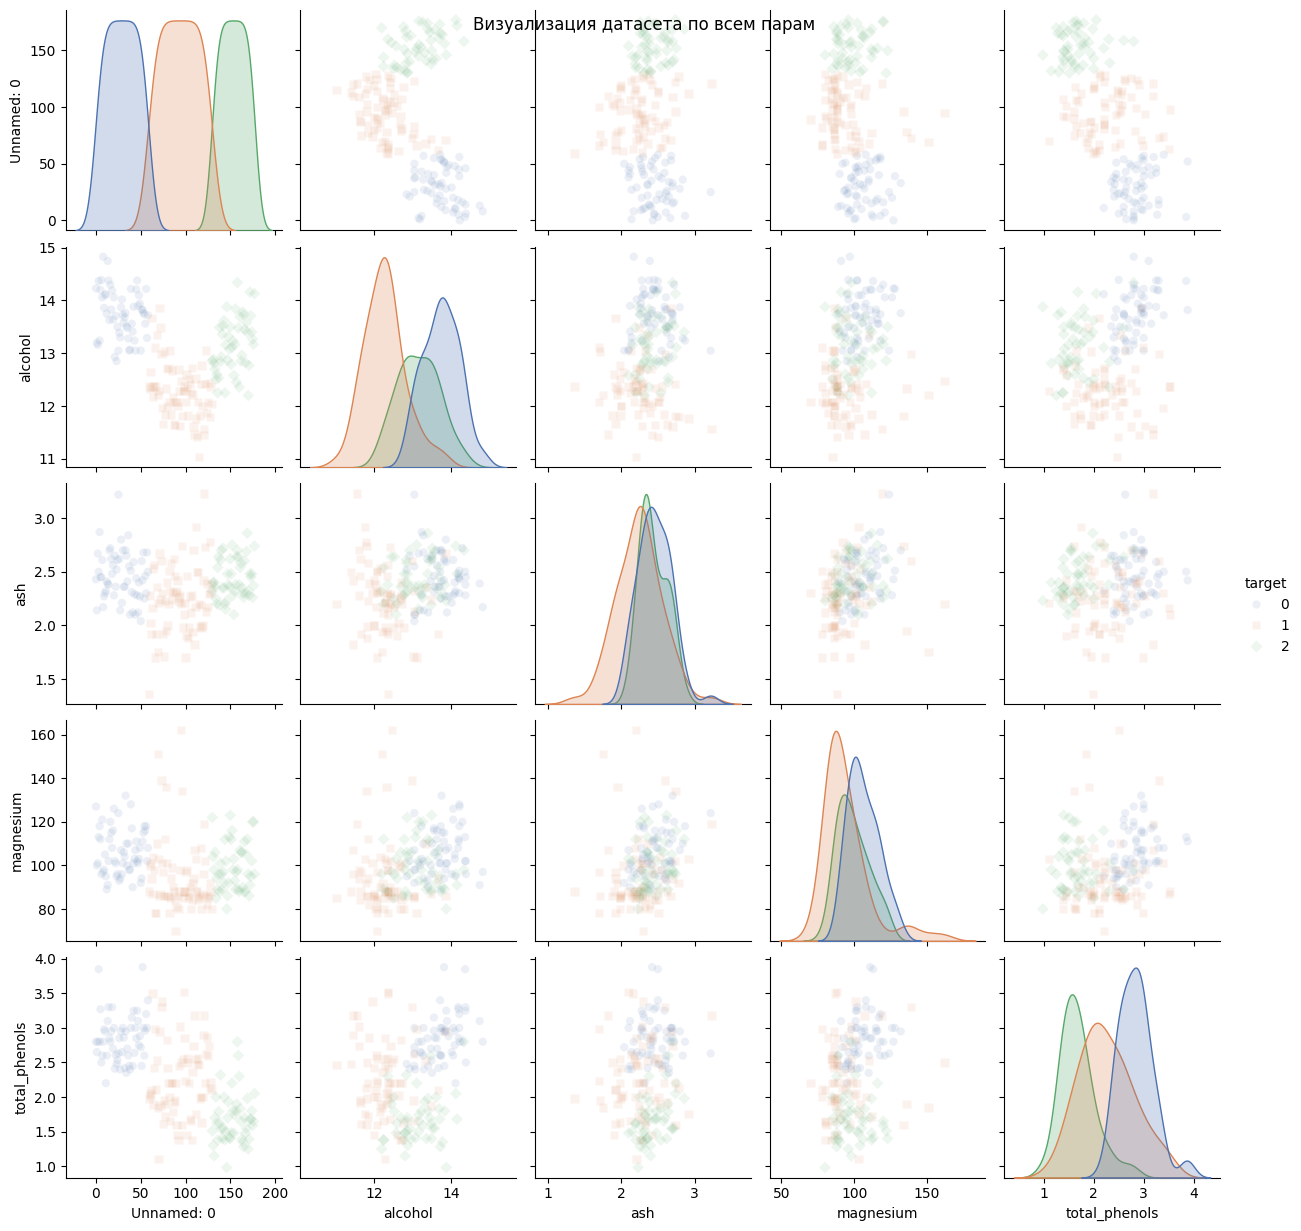

In [13]:
# pairplot = sns.pairplot(filtered_df, hue='target', markers=['o', 's', 'D'], palette='deep', diag_kind='hist', diag_kws={'bins': 20}, plot_kws={'alpha':0.7})
# plt.suptitle('Визуализация датасета по всем парам')
# plt.show()


filtered_df.to_csv('filtered_dataset.csv')
# Чтение обратно из CSV файла
df_from_csv = pd.read_csv('filtered_dataset.csv')
pairplot = sns.pairplot(df_from_csv, hue='target', markers=['o', 's', 'D'], palette='deep', diag_kind='kde', plot_kws={'alpha':0.1})
plt.suptitle('Визуализация датасета по всем парам')
plt.show()

4)

In [4]:
# Оценка корреляции по всему датасету
correlation_matrix = filtered_df[selected_features].corr(method='pearson')

print("Коэффициент корреляции Пирсона по всему датасету:")
print(correlation_matrix)

# Оценка корреляции по каждому классу
class_correlation_matrices = {}
for target_class in filtered_df['target'].unique():
  class_df = filtered_df[filtered_df['target'] == target_class]
  class_correlation_matrix = class_df[selected_features].corr(method='pearson')
  class_correlation_matrices[target_class] = class_correlation_matrix
  print(f"\nКоэффициент корреляции Пирсона для класса {target_class + 1}:")
  print(class_correlation_matrix)


Коэффициент корреляции Пирсона по всему датасету:
                alcohol       ash  magnesium  total_phenols
alcohol        1.000000  0.211545   0.270798       0.289101
ash            0.211545  1.000000   0.286587       0.128980
magnesium      0.270798  0.286587   1.000000       0.214401
total_phenols  0.289101  0.128980   0.214401       1.000000

Коэффициент корреляции Пирсона для класса 1:
                alcohol       ash  magnesium  total_phenols
alcohol        1.000000 -0.148595   0.159361       0.420687
ash           -0.148595  1.000000   0.382549       0.004802
magnesium      0.159361  0.382549   1.000000       0.307241
total_phenols  0.420687  0.004802   0.307241       1.000000

Коэффициент корреляции Пирсона для класса 2:
                alcohol       ash  magnesium  total_phenols
alcohol        1.000000 -0.214851  -0.029911      -0.046321
ash           -0.214851  1.000000   0.129130       0.112146
magnesium     -0.029911  0.129130   1.000000       0.070085
total_phenols -0.0

5)

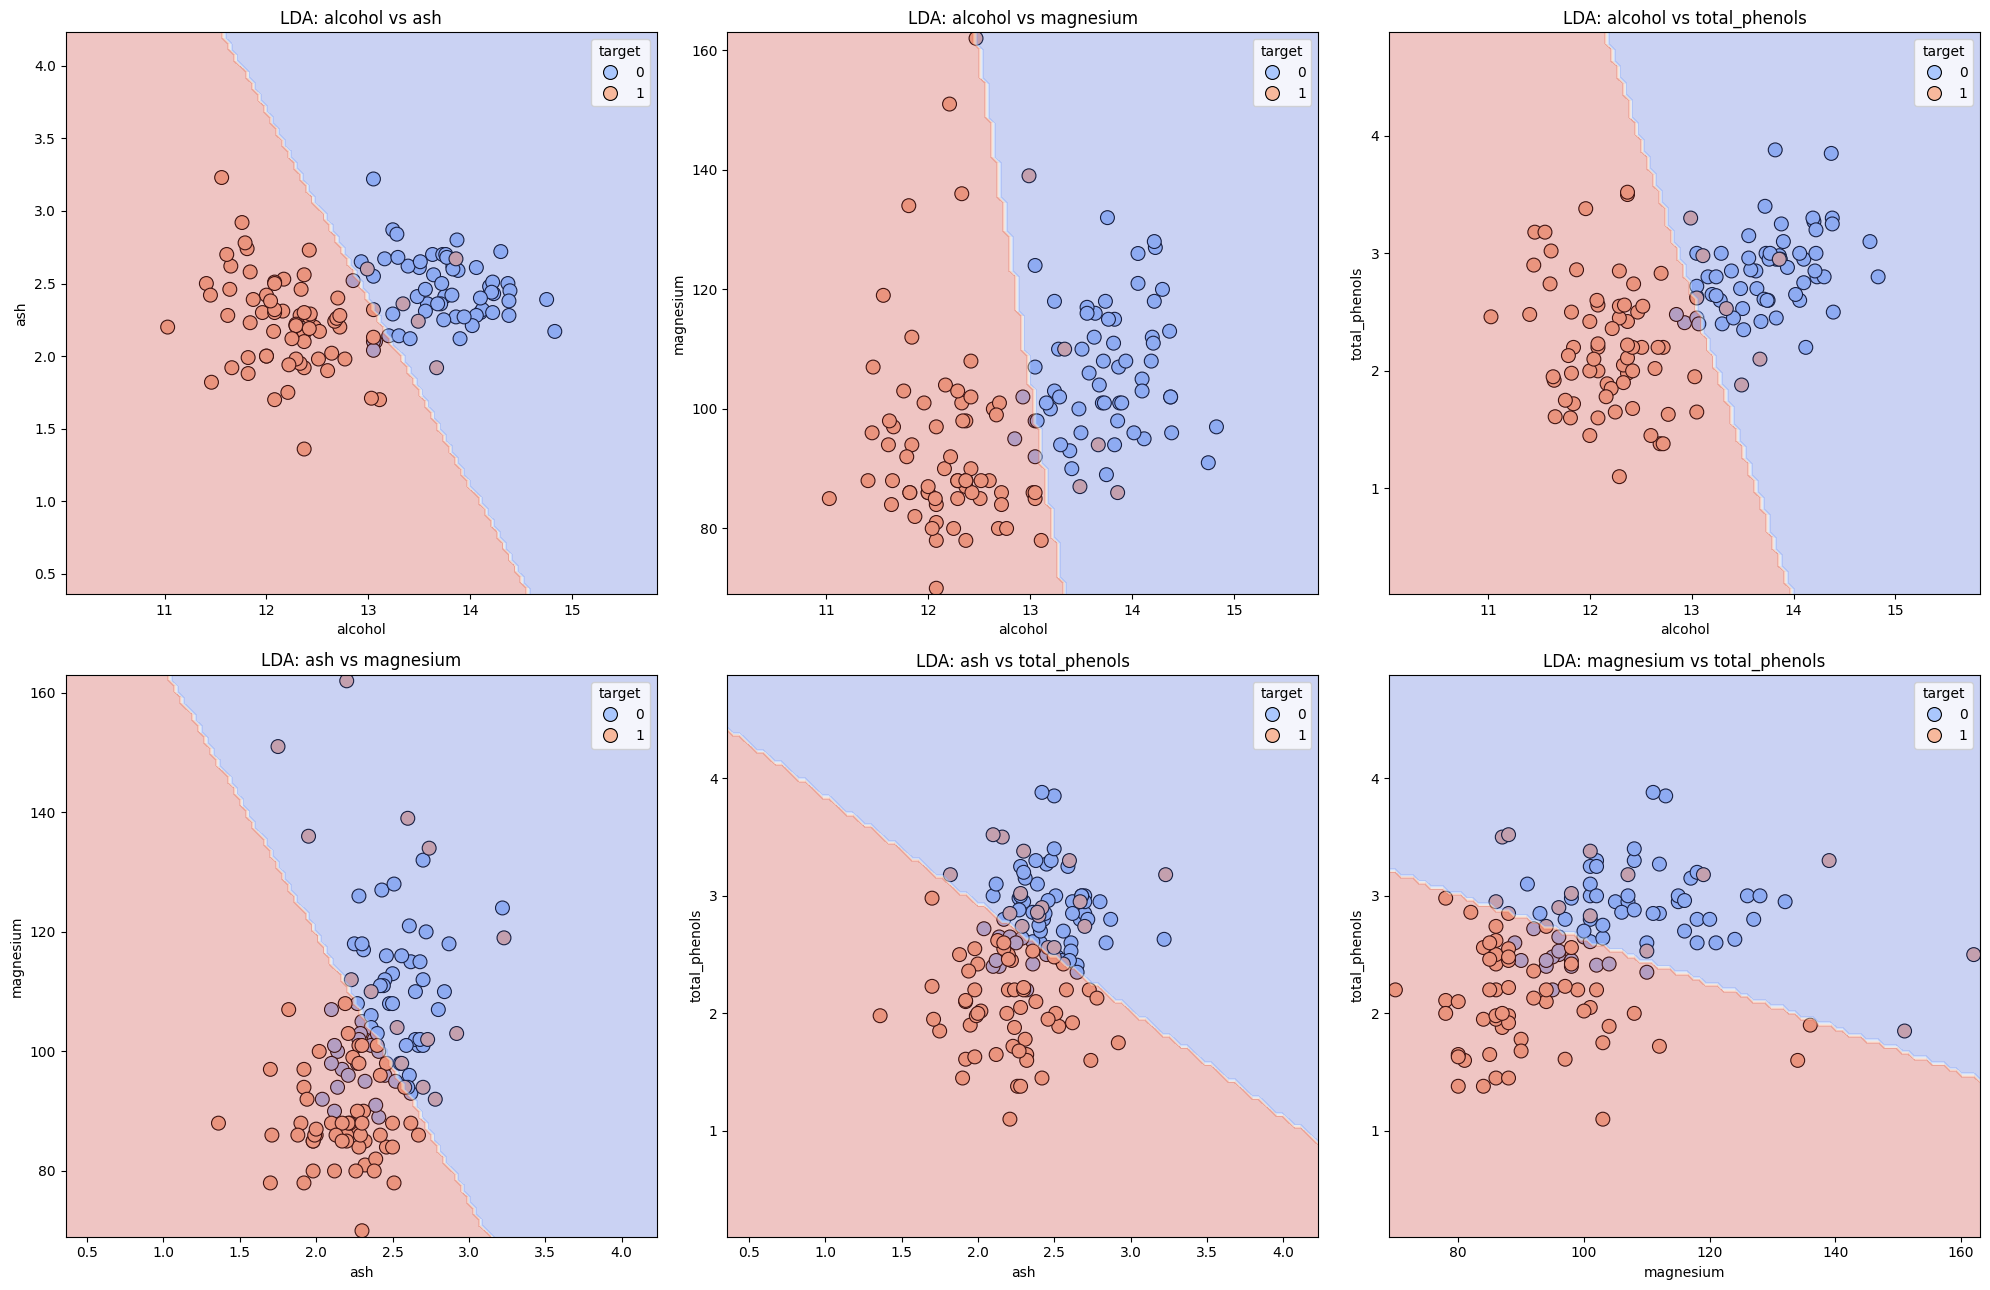

In [5]:
# Фильтруем данные для двух классов (0 и 1)
df_binary = df[df['target'].isin([0, 1])]
X = df_binary[selected_features]
y = df_binary['target']

# Функция для построения границы решающей функции
def plot_lda_decision_boundary(ax, X, y, model, feature1, feature2):
  # Определение границ графика
  x_min, x_max = X[feature1].min() - 1, X[feature1].max() + 1
  y_min, y_max = X[feature2].min() - 1, X[feature2].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  
  # Преобразование в DataFrame для предотвращения предупреждений
  mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
  Z = model.predict(mesh_df)
  Z = Z.reshape(xx.shape)

  sns.scatterplot(x=X[feature1], y=X[feature2], hue=y, palette='coolwarm', edgecolor='k', s=100, ax=ax)
  
  ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
  ax.set_xlabel(feature1)
  ax.set_ylabel(feature2)
  ax.set_title(f"LDA: {feature1} vs {feature2}")

# Графики
n_features = len(selected_features)
n_plots = n_features * (n_features - 1) // 2

fig, axes = plt.subplots(nrows=int(np.ceil(n_plots / (n_features - 1))), ncols=n_features - 1, figsize=(20, 13))

plot_idx = 0
for i in range(n_features):
  for j in range(i + 1, n_features):
    ax = axes[plot_idx // (n_features - 1), plot_idx % (n_features - 1)]
    lda = LinearDiscriminantAnalysis()
    lda.fit(X[[selected_features[i], selected_features[j]]], y)
    plot_lda_decision_boundary(ax, X[[selected_features[i], selected_features[j]]], y, lda, selected_features[i], selected_features[j])
    plot_idx += 1

plt.tight_layout()
plt.show()

6)

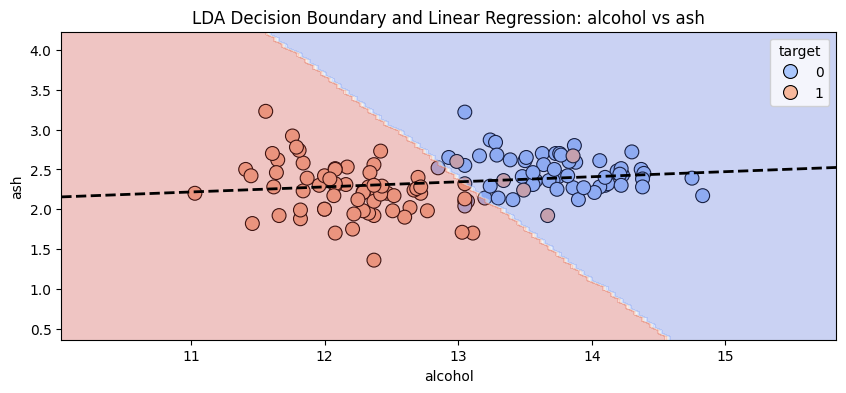

In [6]:
# Функция для построения LDA и регрессии
def plot_lda_and_regression(X, y, lda, feature1, feature2):
  # Определение границ графика
  x_min, x_max = X[feature1].min() - 1, X[feature1].max() + 1
  y_min, y_max = X[feature2].min() - 1, X[feature2].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  
  # Преобразование в DataFrame для предотвращения предупреждений
  mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
  Z = lda.predict(mesh_df)
  Z = Z.reshape(xx.shape)

  # Линейная регрессия
  reg = LinearRegression()
  reg.fit(X[[feature1]].values, X[feature2].values)
  reg_line = reg.predict(np.linspace(x_min, x_max, 100).reshape(-1, 1))
  
  # График
  fig, ax = plt.subplots(figsize=(10, 4))

  sns.scatterplot(x=X[feature1], y=X[feature2], hue=y, palette='coolwarm', edgecolor='k', s=100, ax=ax)  # Точки данных
  ax.plot(np.linspace(x_min, x_max, 100), reg_line, color='black', linestyle='--', linewidth=2)  # Линия линейной регрессии
  
  ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')  # Граница LDA
  ax.set_xlabel(feature1)
  ax.set_ylabel(feature2)
  ax.set_title(f"LDA Decision Boundary and Linear Regression: {feature1} vs {feature2}")
  
  plt.show()

# Выбрал пару признаков
feature1, feature2 = selected_features[0], selected_features[1]

lda = LinearDiscriminantAnalysis()
lda.fit(X[[feature1, feature2]], y)
plot_lda_and_regression(X, y, lda, feature1, feature2)

7)

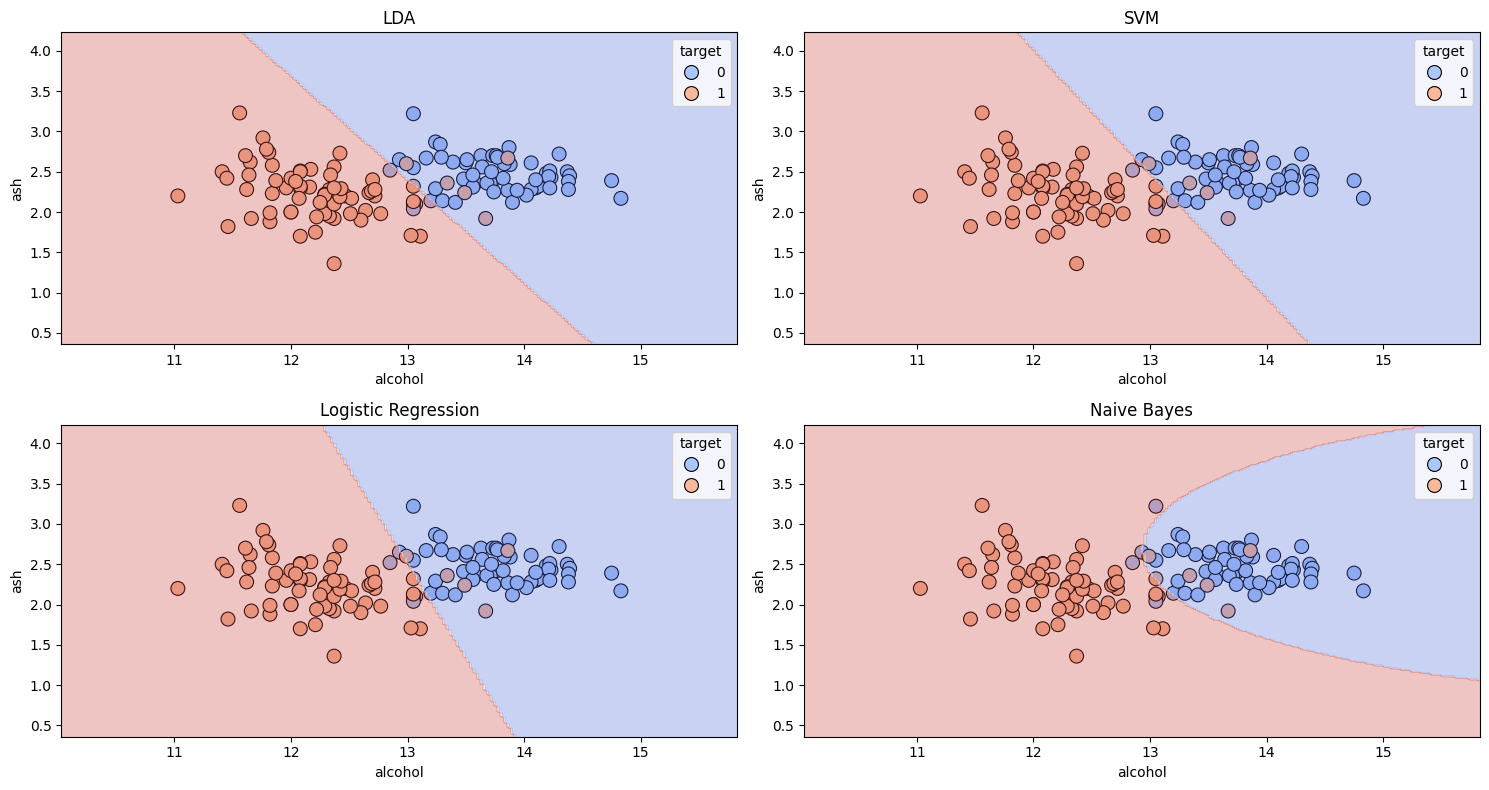

In [7]:
 # Функция для построения методов
def plot_decision_boundary(ax, X, y, model, feature1, feature2, title):
  # Определение границ графика
  x_min, x_max = X[feature1].min() - 1, X[feature1].max() + 1
  y_min, y_max = X[feature2].min() - 1, X[feature2].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

  # Преобразование сетки в DataFrame для предсказания
  mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
  Z = model.predict(mesh_df)
  Z = Z.reshape(xx.shape)

  sns.scatterplot(x=X[feature1], y=X[feature2], hue=y, palette='coolwarm', edgecolor='k', s=100, ax=ax)
  ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
  ax.set_xlabel(feature1)
  ax.set_ylabel(feature2)
  ax.set_title(title)

# Выбор двух количественных признаков и пары целевых классов
X_f1_f2 = df_binary[[feature1, feature2]]

# Определение моделей
models = {
    'LDA': LinearDiscriminantAnalysis(),  # 1. Линейный дискриминантный анализ
    'SVM': SVC(kernel='linear', C=1, probability=True), # 2. Метод опорных векторов, probability=True для получения вероятностей
    'Logistic Regression': LogisticRegression(), # 3. Логистическая регрессия
    'Naive Bayes': GaussianNB() # 4. Наивный байесовский классификатор
}

# Графики
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()
cnt_axe = 0

for name, model in models.items():
  model.fit(X_f1_f2, y)
  plot_decision_boundary(axes[cnt_axe], X_f1_f2, y, model, feature1, feature2, name)
  cnt_axe+=1

plt.tight_layout()
plt.show()

8)

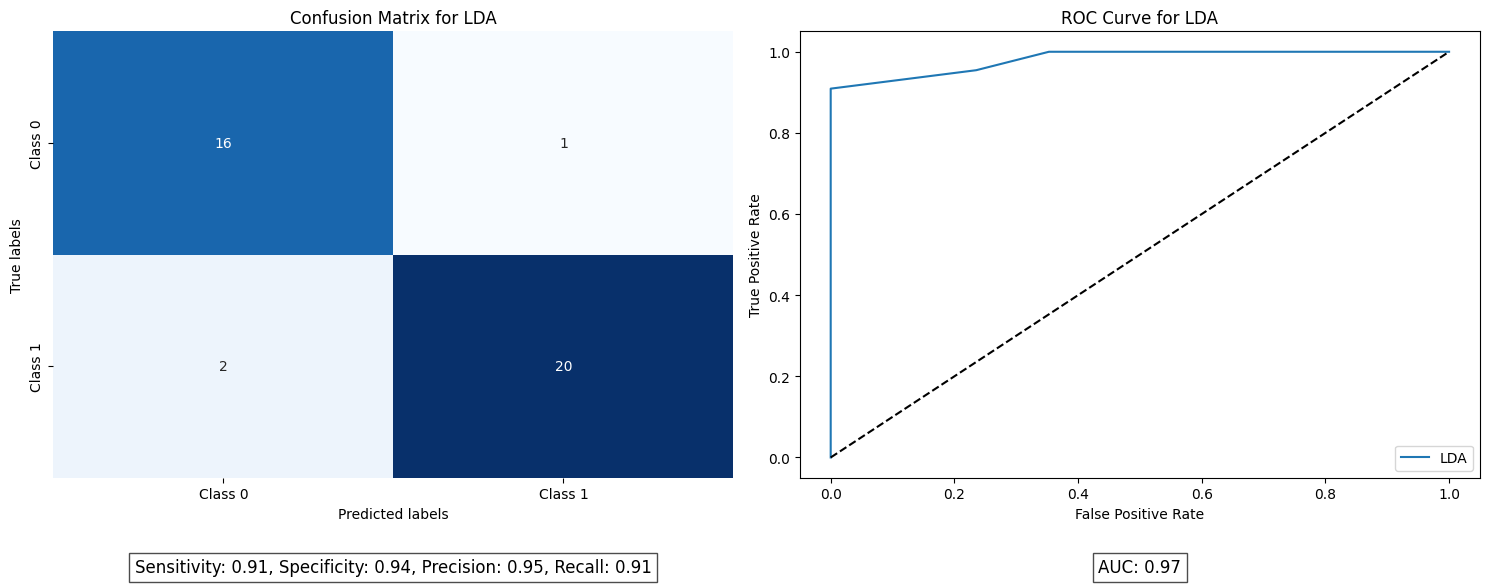

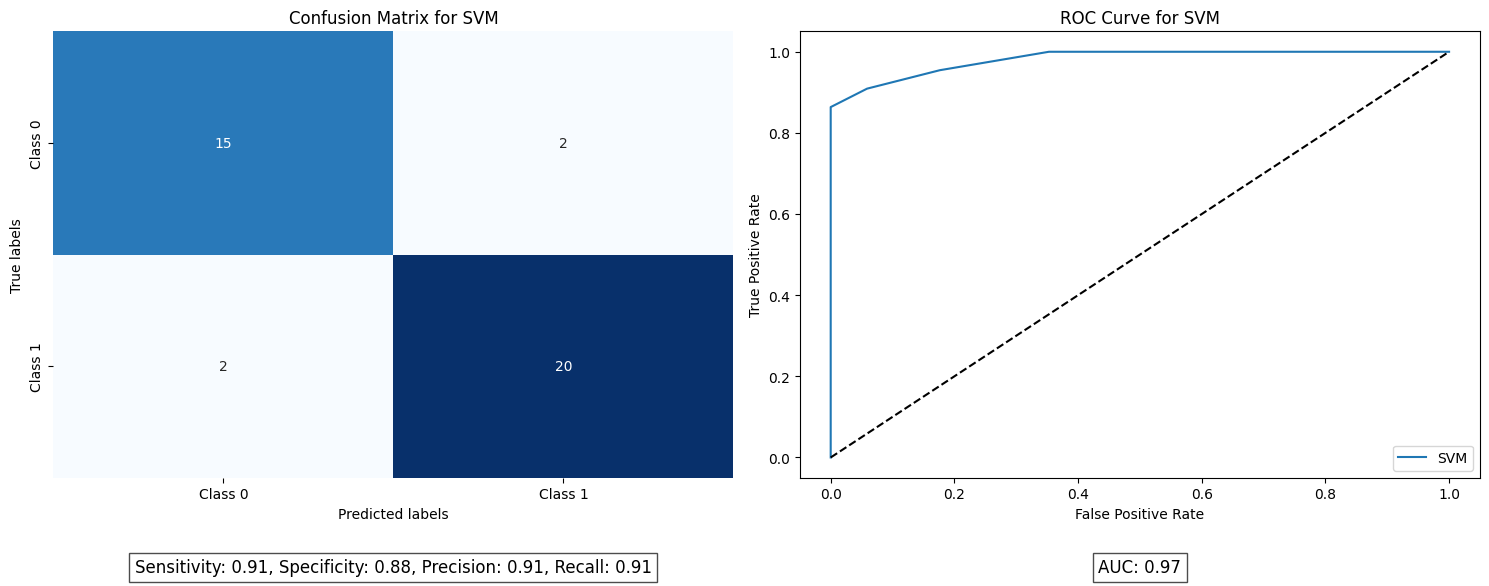

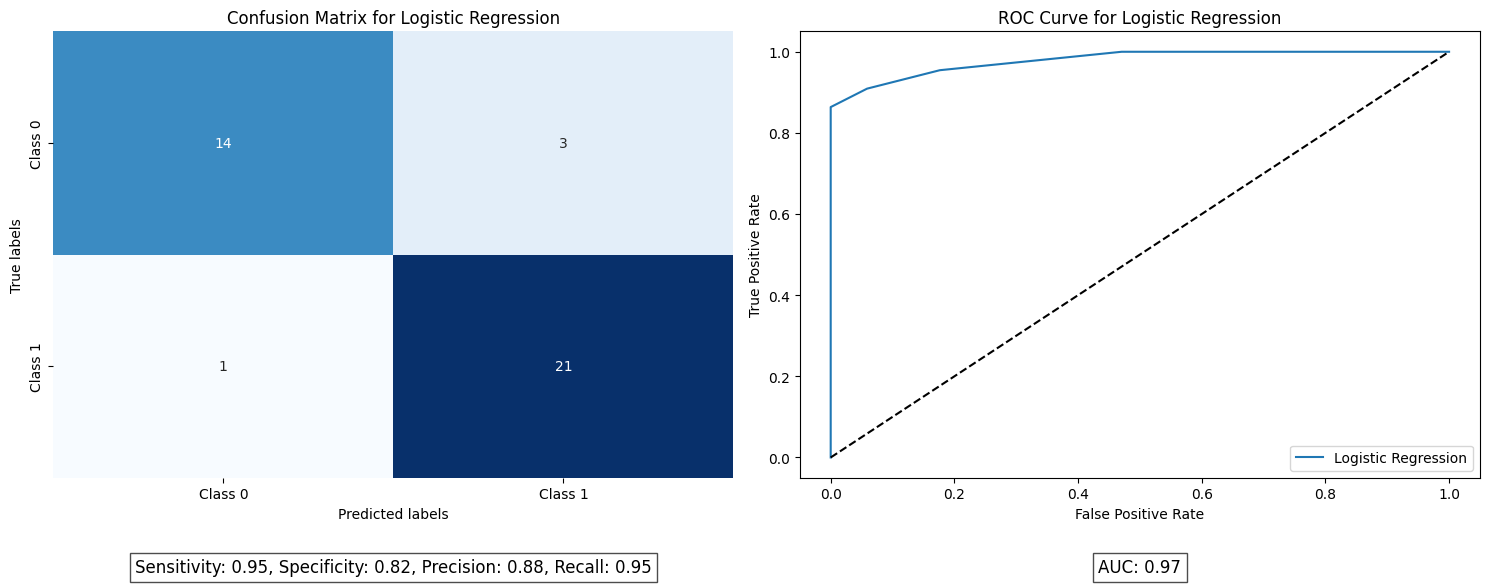

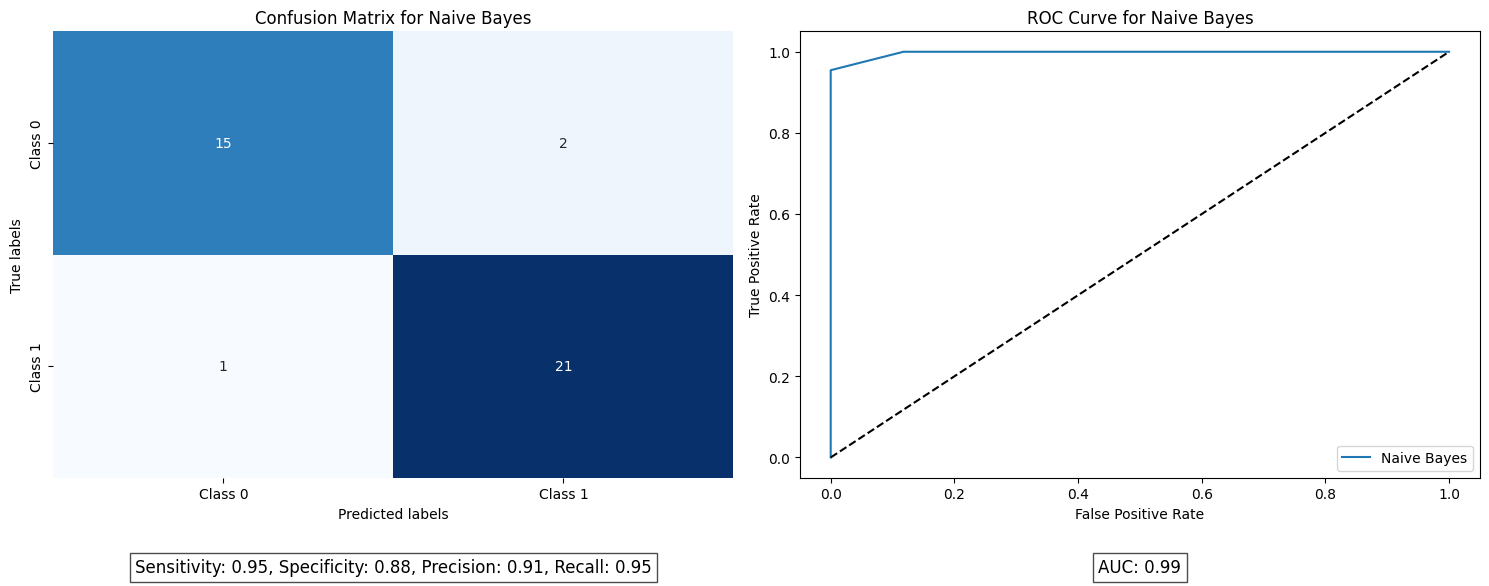

In [8]:
# Функция для оценки модели
def evaluate_model(name, model, X, y):
  # Разбиваем датасет
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

  # Обучение модели
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  # Определение вероятностей для AUC и ROC, если метод доступен
  if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
  else:
    y_proba = np.zeros_like(y_pred)  # Если predict_proba недоступен, используем заглушку
  
  # Матрица ошибок
  conf_matrix = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = conf_matrix.ravel()
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  
  # ROC кривая и AUC
  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc = roc_auc_score(y_test, y_proba)
  
  # Фильтрация ступенек
  filtered_fpr = [fpr[0]]
  filtered_tpr = [tpr[0]] 
  for i in range(1, len(fpr)):
    if tpr[i] != tpr[i - 1]:
      filtered_fpr.append(fpr[i])
      filtered_tpr.append(tpr[i])
  filtered_fpr.append(fpr[-1])
  filtered_tpr.append(tpr[-1])
  
  # Построение графиков
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))
  
  # Матрица ошибок
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
              xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=axes[0])
  axes[0].set_xlabel('Predicted labels')
  axes[0].set_ylabel('True labels')
  axes[0].set_title(f'Confusion Matrix for {name}')
  axes[0].text(0.5, -0.2, f'Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}',
                ha='center', va='center', transform=axes[0].transAxes,
                fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
  
  # ROC кривая
  axes[1].plot(filtered_fpr, filtered_tpr, label=f'{name}')
  axes[1].plot([0, 1], [0, 1], 'k--')
  axes[1].set_xlabel('False Positive Rate')
  axes[1].set_ylabel('True Positive Rate')
  axes[1].set_title(f'ROC Curve for {name}')
  axes[1].text(0.5, -0.2, f'AUC: {auc:.2f}', ha='center', va='center', transform=axes[1].transAxes,
                fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
  axes[1].legend(loc="lower right")
  
  plt.tight_layout()
  plt.show()

# Оценка моделей
for name, model in models.items():
  evaluate_model(name, model, X, y)
